In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(magrittr)
    library(harmony)
    data(pbmc_stim)    
})

# Preprocess

In [3]:
pbmc <- CreateSeuratObject(raw.data = cbind(stim.sparse, ctrl.sparse), project = "PBMC", min.cells = 5)
pbmc@meta.data$stim <- c(rep("STIM", ncol(stim.sparse)), rep("CTRL", ncol(ctrl.sparse)))

pbmc %<>% Seurat::NormalizeData()
pbmc@var.genes <- split(row.names(pbmc@meta.data), pbmc@meta.data$stim) %>% lapply(function(cells_use) {
    temp_data <- SubsetData(pbmc, cells_use)
    temp_data %<>% FindVariableGenes(do.plot = FALSE)
    head(rownames(temp_data@hvg.info), 1000)
}) %>% unlist %>% unique
pbmc %<>% ScaleData()
pbmc %<>% RunPCA(pc.genes = pbmc@var.genes, pcs.compute = 20, do.print = TRUE, pcs.print = 1:5, genes.print = 5)

Scaling data matrix


[1] "PC1"
[1] "RPL21"  "RPS6"   "RPL3"   "RPL13A" "RPL7"  
[1] ""
[1] "TYROBP"   "C15orf48" "FCER1G"   "SOD2"     "CST3"    
[1] ""
[1] ""
[1] "PC2"
[1] "IL8"      "CD14"     "MARCKSL1" "S100A8"   "GPX1"    
[1] ""
[1] "NKG7" "GNLY" "GZMB" "PRF1" "CCL5"
[1] ""
[1] ""
[1] "PC3"
[1] "ISG15" "IFIT3" "IFIT1" "ISG20" "IFIT2"
[1] ""
[1] "NKG7" "GZMB" "GNLY" "IL8"  "CCL5"
[1] ""
[1] ""
[1] "PC4"
[1] "B2M"    "HLA-B"  "HLA-C"  "TMSB4X" "HLA-A" 
[1] ""
[1] "HBA1"  "HBA2"  "HBB"   "ALAS2" "SNCA" 
[1] ""
[1] ""
[1] "PC5"
[1] "CD79A"    "CD74"     "HLA-DQA1" "CD83"     "HLA-DPA1"
[1] ""
[1] "GIMAP7" "CD3D"   "ANXA1"  "GIMAP5" "GIMAP4"
[1] ""
[1] ""


# Perform an integrated analysis

    The RunHarmony function will integrate datasets defined by the "stim" column in the Seurat Object's meta.data 
    
        pbmc@meta.data
    
    If you want to integrate on another variable, just add that column to the meta.data
    
        pbmc@meta.data$my_new_var <- my_new_var_vector
        
        
    The plot below shows the convergence of the Harmony objective function over each iteration of Harmony. 
    Each point is a single cluster step. 
    Different colors represent different Harmony iterations. 

Starting harmony
Using top 20 PCs
Harmony 1/4
Harmony 2/4
Harmony 3/4
Harmony 4/4


Clustered for 70 iterations


   user  system elapsed 
 56.055   3.081  63.408 

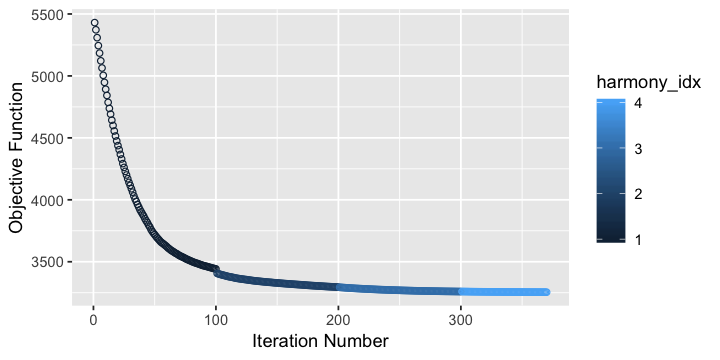

In [4]:
options(repr.plot.height = 3, repr.plot.width = 6)
system.time(pbmc %<>% RunHarmony("stim", theta = 2, plot_convergence = TRUE, nclust = 50, 
                                 max.iter.cluster = 100, max.iter.harmony = 4))

After Harmony integration, cells align along the Harmonized PCs. If they did not, you could increase the *theta* value above and rerun the analysis. 

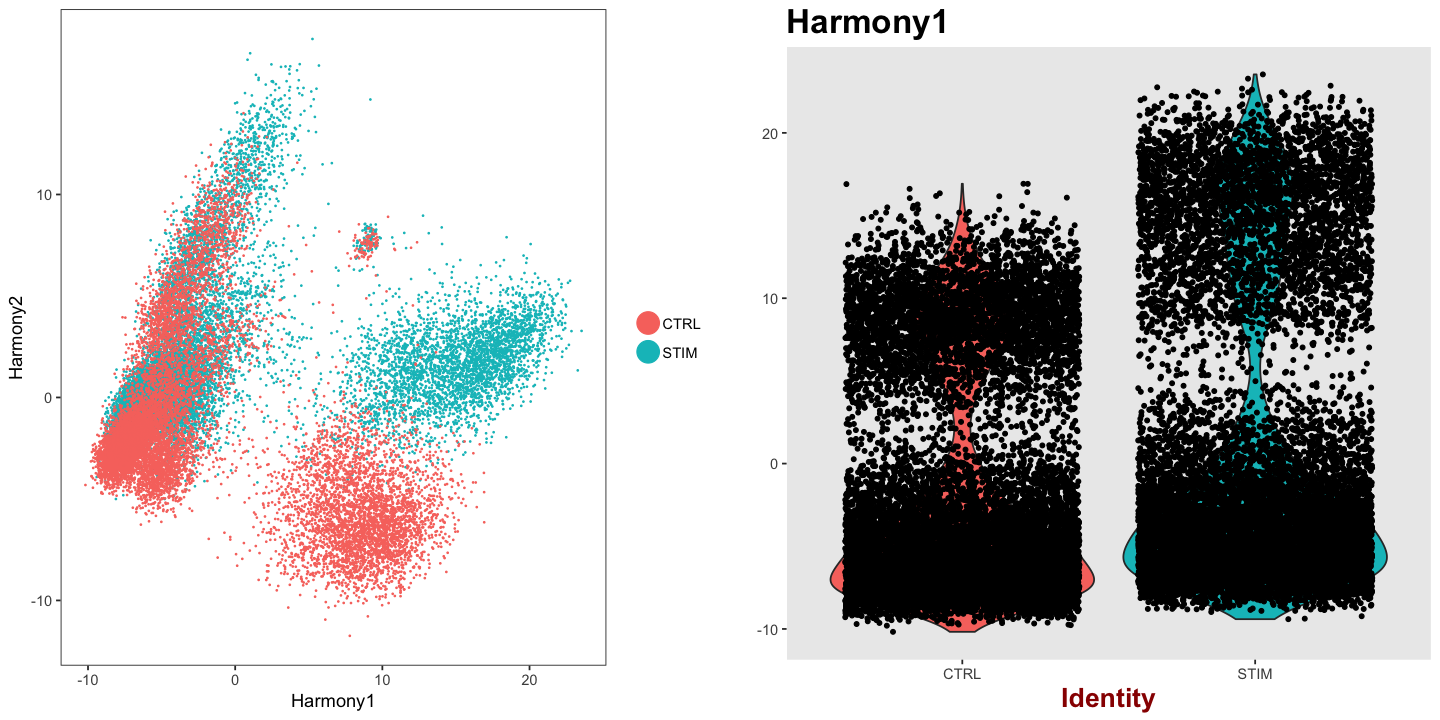

In [5]:
options(repr.plot.height = 6, repr.plot.width = 12)
p1 <- DimPlot(object = pbmc, reduction.use = "harmony", pt.size = .1, group.by = "stim", do.return = T)
p2 <- VlnPlot(object = pbmc, features.plot = "Harmony1", group.by = "stim", do.return = TRUE)
plot_grid(p1,p2)

Genes correlated with the Harmonized PCs

In [6]:
PrintDim(object = pbmc, reduction.type = "harmony", dims.print = 1:5, genes.print = 10)

[1] "Harmony1"
 [1] "RPL21"  "RPS6"   "RPL3"   "RPL13A" "RPL7"   "RPS3"   "RPS18"  "RPL13" 
 [9] "RPS14"  "RPS27A"
[1] ""
 [1] "TYROBP"   "C15orf48" "FCER1G"   "SOD2"     "CST3"     "TYMP"    
 [7] "CD63"     "ANXA5"    "TIMP1"    "APOBEC3A"
[1] ""
[1] ""
[1] "Harmony2"
 [1] "IL8"      "CD14"     "MARCKSL1" "S100A8"   "CLEC5A"   "HLA-DRA" 
 [7] "GPX1"     "VCAN"     "PLAUR"    "FTH1"    
[1] ""
 [1] "NKG7"     "GNLY"     "GZMB"     "PRF1"     "CCL5"     "APOBEC3G"
 [7] "CST7"     "CLIC3"    "KLRD1"    "GZMA"    
[1] ""
[1] ""
[1] "Harmony3"
 [1] "ISG15"   "IFIT3"   "IFIT1"   "ISG20"   "IFIT2"   "TNFSF10" "CXCL10" 
 [8] "MX1"     "RSAD2"   "IFI6"   
[1] ""
 [1] "NKG7"   "GZMB"   "GNLY"   "IL8"    "CCL5"   "CST7"   "CLEC5A" "CD14"  
 [9] "VCAN"   "FGFBP2"
[1] ""
[1] ""
[1] "Harmony4"
 [1] "B2M"    "HLA-B"  "HLA-C"  "TMSB4X" "HLA-A"  "NKG7"   "CYBA"   "MALAT1"
 [9] "GZMB"   "CCL5"  
[1] ""
 [1] "HBA1"        "HBA2"        "HBB"         "ALAS2"       "SNCA"       
 [6] "HBD"         "CA1" 

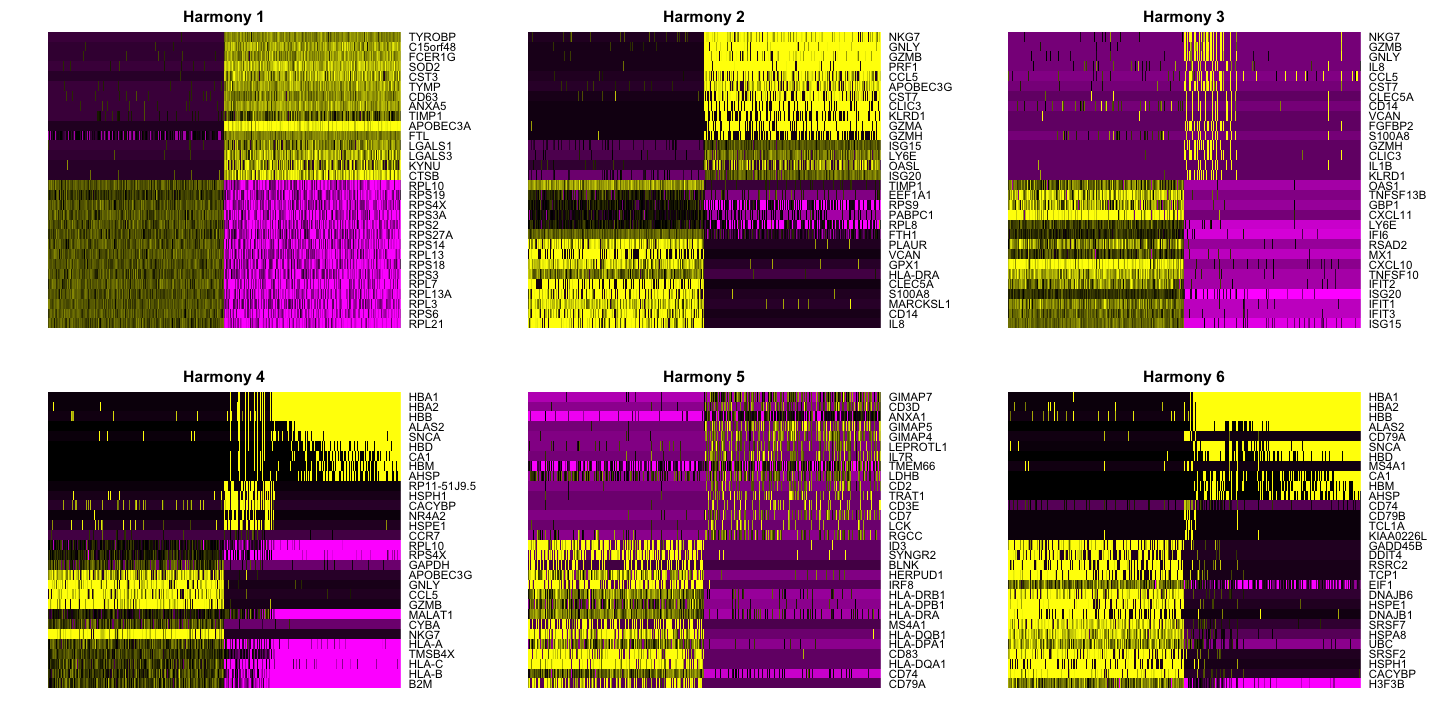

In [7]:
DimHeatmap(object = pbmc, reduction.type = "harmony", cells.use = 500, dim.use = 1:6, do.balanced = TRUE)

# Seurat tSNE Functions for Integrated Analysis Using Harmony Results

Similar to the linked vigenette, the harmony results can be used for integrated analysis. You simply replace the CCA dimensional reduction with Harmony.

In [183]:
system.time({
pbmc %<>% RunTSNE(reduction.use = "harmony", dims.use = 1:20, do.fast = T)
pbmc %<>% FindClusters(reduction.type = "harmony", resolution = 0.6, dims.use = 1:20, force.recalc = TRUE, print.output = FALSE)
})


   user  system elapsed 
315.633   0.002 316.004 

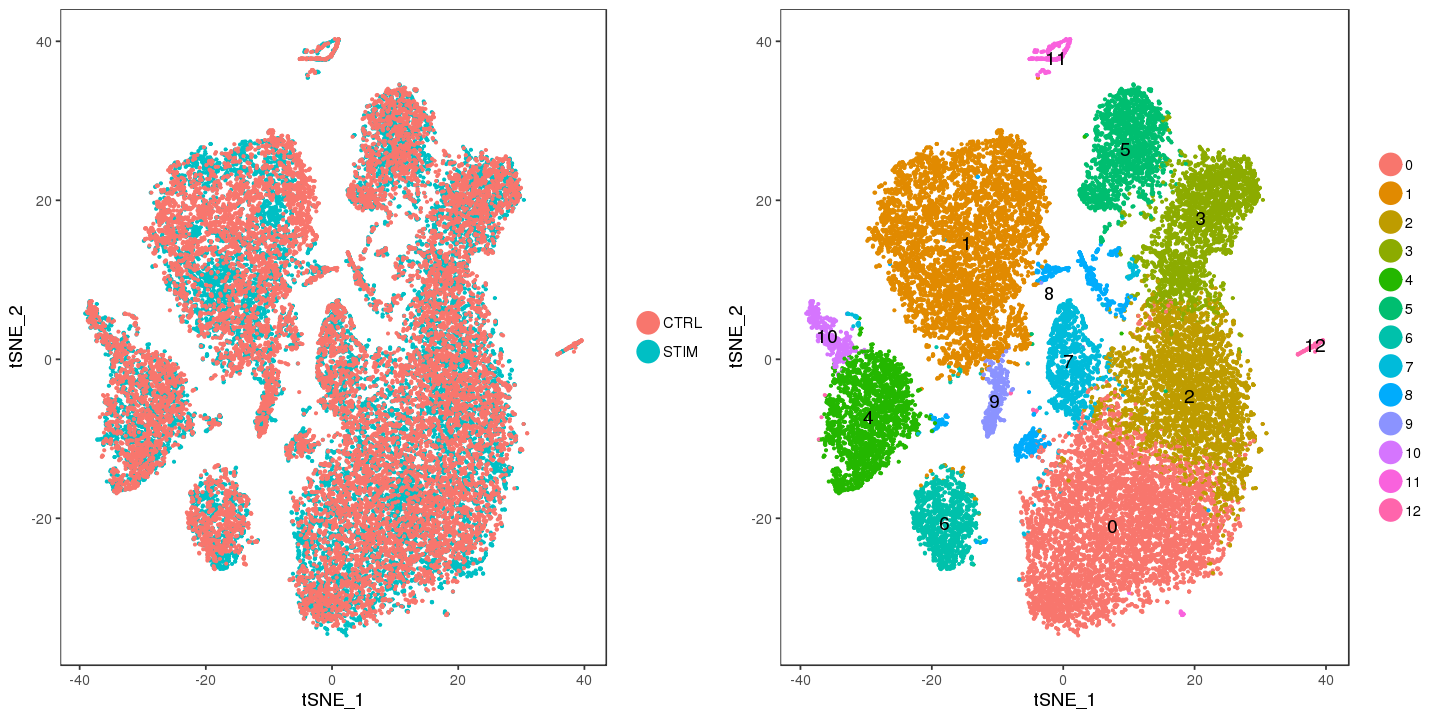

In [184]:
p3 <- TSNEPlot(pbmc, do.return = T, pt.size = 0.5, group.by = "stim")
p4 <- TSNEPlot(pbmc, do.label = T, do.return = T, pt.size = 0.5)
plot_grid(p3, p4)

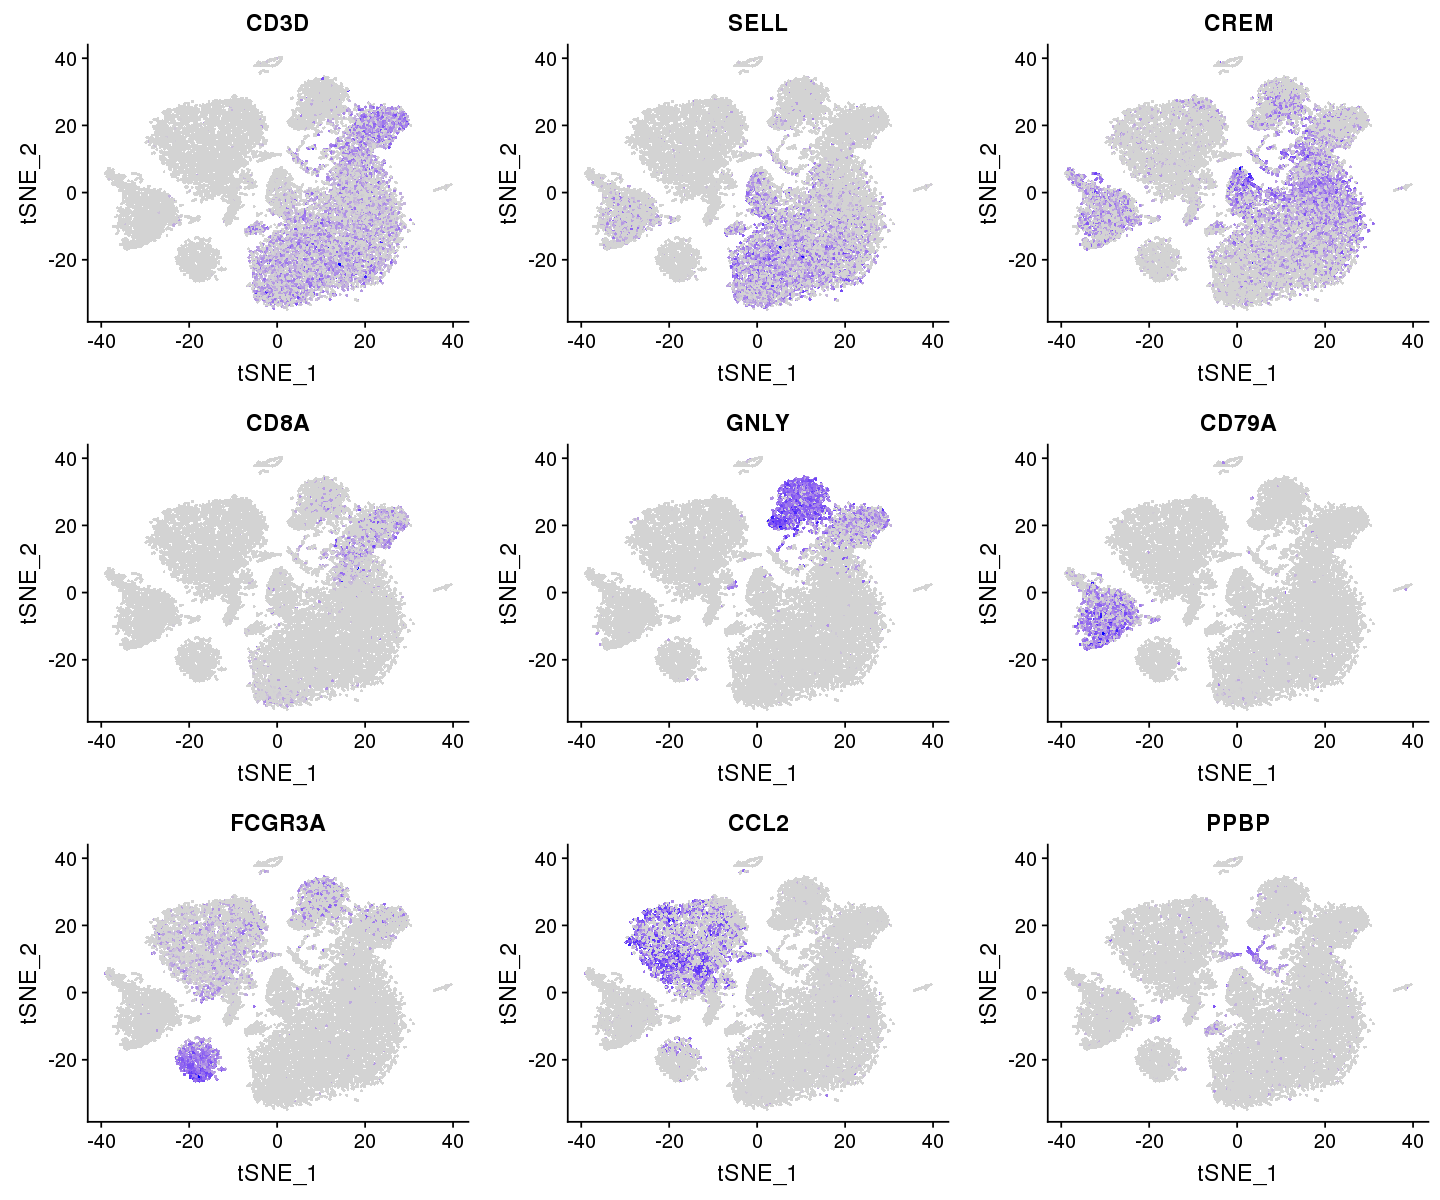

In [188]:
options(repr.plot.height = 10, repr.plot.width = 12)
FeaturePlot(object = pbmc, features.plot = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", "CCL2", "PPBP"), 
            min.cutoff = "q9", cols.use = c("lightgrey", "blue"), pt.size = 0.5)